# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/sample_data.csv`.

In [2]:
import os
import pandas as pd
import numpy as np

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Define the sample data
data = {
    'age': [34, 45, 29, 50, 38, np.nan, 41],
    'income': [55000, np.nan, 42000, 58000, np.nan, np.nan, 49000],
    'score': [0.82, 0.91, np.nan, 0.76, 0.88, 0.65, 0.79],
    'zipcode': ['90210', '10001', '60614', '94103', '73301', '12345', '94105'],
    'city': ['Beverly', 'New York', 'Chicago', 'SF', 'Austin', 'Unknown', 'San Francisco'],
    'extra_data': [np.nan, 42, np.nan, np.nan, np.nan, 5, np.nan]
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'sample_data.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Sample dataset created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')


File already exists at ../data/raw/sample_data.csv. Skipping CSV creation to avoid overwrite.


# Homework Starter — Stage 6: Data Preprocessing
Use this notebook to apply your cleaning functions and save processed data.

In [22]:
import pandas as pd
from src import cleaning
import os

## Load Raw Dataset

In [7]:
df = pd.read_csv('../data/raw/sample_data.csv')
print(df.head())

    age   income  score  zipcode      city  extra_data
0  34.0  55000.0   0.82    90210   Beverly         NaN
1  45.0      NaN   0.91    10001  New York        42.0
2  29.0  42000.0    NaN    60614   Chicago         NaN
3  50.0  58000.0   0.76    94103        SF         NaN
4  38.0      NaN   0.88    73301    Austin         NaN


## Apply Cleaning Functions

In [24]:
import pandas as pd
from src import cleaning

df_clean = cleaning.fill_missing_median(df)
df_clean = cleaning.drop_missing(df_clean, threshold=0.5)
df_clean = cleaning.normalize_data(df_clean, method="standard")
df_clean = cleaning.fill_missing_general(df)


df_clean


,age,income,score,zipcode,city,extra_data
0,34.0,55000.0,0.820,90210,Beverly,23.5
1,45.0,52000.0,0.910,10001,New York,42.0
2,29.0,42000.0,0.805,60614,Chicago,23.5
3,50.0,58000.0,0.760,94103,SF,23.5
4,38.0,52000.0,0.880,73301,Austin,23.5
5,39.5,52000.0,0.650,12345,Unknown,5.0
6,41.0,49000.0,0.790,94105,San Francisco,23.5


## Save Cleaned Dataset

In [20]:
import os


os.makedirs("data", exist_ok=True)
df_clean.to_csv('data/processed/cleaned_data.csv', index=False)
df_clean.head()


,age,income,score,zipcode,city,extra_data
0,34.0,55000.0,0.820,90210,Beverly,23.5
1,45.0,52000.0,0.910,10001,New York,42.0
2,29.0,42000.0,0.805,60614,Chicago,23.5
3,50.0,58000.0,0.760,94103,SF,23.5
4,38.0,52000.0,0.880,73301,Austin,23.5


## Compare original vs cleaned data

=== Overview ===
raw shape: (7, 6) | cleaned shape: (7, 6)

=== Missingness comparison (%) ===


,raw,cleaned
extra_data,71.43,0.0
income,42.86,0.0
age,14.29,0.0
score,14.29,0.0
city,0.00,0.0
zipcode,0.00,0.0


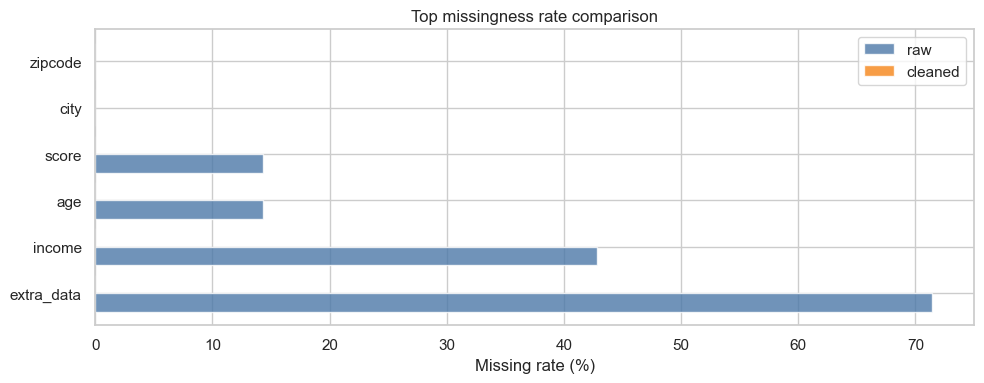

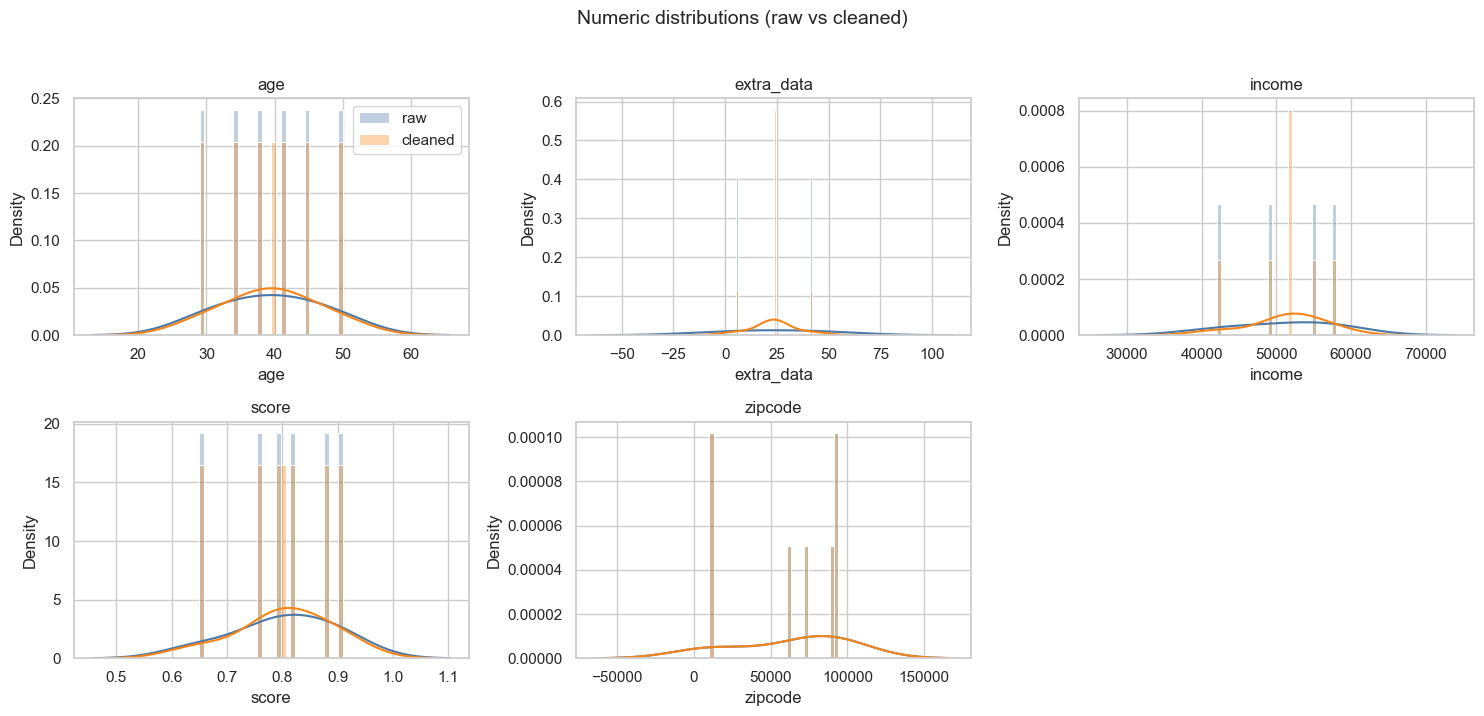


=== Summary stats difference (cleaned - raw) ===


stat,count,mean,std,50%,min,max
age,1.0,0.000,-0.658,0.0,0.0,0.0
extra_data,5.0,0.000,-15.482,0.0,0.0,0.0
income,3.0,428.571,-2042.578,0.0,0.0,0.0
score,1.0,0.000,-0.008,0.0,0.0,0.0
zipcode,0.0,0.000,0.000,0.0,0.0,0.0


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def compare_df(df, df_cleaned, max_numeric=6, bins=30, top_n_missing=15, kde=True):
    print("=== Overview ===")
    print(f"raw shape: {df.shape} | cleaned shape: {df_cleaned.shape}")
    raw_cols, clean_cols = set(df.columns), set(df_cleaned.columns)
    dropped = sorted(raw_cols - clean_cols)
    added = sorted(clean_cols - raw_cols)
    if dropped:
        print(f"Dropped columns after cleaning ({len(dropped)}): {dropped[:10]}{' ...' if len(dropped)>10 else ''}")
    if added:
        print(f"Added columns after cleaning ({len(added)}): {added[:10]}{' ...' if len(added)>10 else ''}")

    # Missingness comparison
    print("\n=== Missingness comparison (%) ===")
    all_cols = sorted(list(raw_cols | clean_cols))
    miss_raw = df.reindex(columns=all_cols).isna().mean()*100
    miss_clean = df_cleaned.reindex(columns=all_cols).isna().mean()*100
    miss_df = pd.DataFrame({"raw": miss_raw, "cleaned": miss_clean}).fillna(0)
    miss_df["max_any"] = miss_df.max(axis=1)
    miss_top = miss_df.sort_values("max_any", ascending=False).head(top_n_missing).drop(columns="max_any")
    display(miss_top.round(2))

    if not miss_top.empty:
        fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(miss_top))))
        y = np.arange(len(miss_top))
        ax.barh(y-0.2, miss_top["raw"].values, height=0.4, label="raw", color="#4C78A8", alpha=0.8)
        ax.barh(y+0.2, miss_top["cleaned"].values, height=0.4, label="cleaned", color="#F58518", alpha=0.8)
        ax.set_yticks(y)
        ax.set_yticklabels(miss_top.index)
        ax.set_xlabel("Missing rate (%)")
        ax.set_title("Top missingness rate comparison")
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Numeric columns distribution comparison
    num_raw = set(df.select_dtypes(include=np.number).columns)
    num_clean = set(df_cleaned.select_dtypes(include=np.number).columns)
    numeric_cols = sorted(list(num_raw & num_clean))
    if not numeric_cols:
        print("\nNo common numeric columns found; skipping distribution comparison.")
        return

    cols_to_plot = numeric_cols[:max_numeric]
    n = len(cols_to_plot)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.5*nrows))
    axes = np.atleast_2d(axes)
    for i, col in enumerate(cols_to_plot):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        sns.histplot(df[col].dropna(), bins=bins, stat="density", color="#4C78A8", alpha=0.35, label="raw", ax=ax)
        sns.histplot(df_cleaned[col].dropna(), bins=bins, stat="density", color="#F58518", alpha=0.35, label="cleaned", ax=ax)
        if kde:
            if df[col].dropna().nunique() > 1:
                sns.kdeplot(df[col].dropna(), color="#4C78A8", ax=ax)
            if df_cleaned[col].dropna().nunique() > 1:
                sns.kdeplot(df_cleaned[col].dropna(), color="#F58518", ax=ax)
        ax.set_title(col)
        if i == 0:
            ax.legend()
    # Remove empty subplots
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        fig.delaxes(axes[r, c])
    fig.suptitle("Numeric distributions (raw vs cleaned)", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Summary statistics differences
    raw_desc = df[cols_to_plot].describe().rename_axis("stat")
    clean_desc = df_cleaned[cols_to_plot].describe().rename_axis("stat")
    sel_stats = ["count", "mean", "std", "50%", "min", "max"]
    common_stats = [s for s in sel_stats if s in raw_desc.index and s in clean_desc.index]
    diff = (clean_desc.loc[common_stats] - raw_desc.loc[common_stats]).T
    print("\n=== Summary stats difference (cleaned - raw) ===")
    display(diff.round(3))

compare_df(df, df_clean)